In [2]:
import os
import sys
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation, Dense, Flatten
from keras.layers.convolutional import Convolution1D,AveragePooling1D,MaxPooling1D

In [4]:
Mn2_C = (pd.read_pickle('Mn2_Larger_Clean_Thin.pkl'))

In [5]:
Mn3_C = (pd.read_pickle('Mn3_Larger_Clean_Thin.pkl'))
Mn4_C = (pd.read_pickle('Mn4_Larger_Clean_Thin.pkl'))
Mn_All = (Mn2_C.append(Mn3_C, ignore_index=True)).append(Mn4_C, ignore_index=True)
Mn_All = np.array(Mn_All)

In [6]:
labels=[]
for i in range(0, len(Mn2_C)):
    labels.append(0)
for i in range(0, len(Mn3_C)):
    labels.append(1)
for i in range(0, len(Mn4_C)):
    labels.append(2)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Mn_All, labels, test_size=0.15, random_state=13)

In [8]:
noise_aug = []
noise = np.copy(X_train)
mu = np.mean(noise, axis=0)
pca = PCA()
noise_model = pca.fit(noise)
nComp = 10
Xhat = np.dot(pca.transform(noise)[:,:nComp], pca.components_[:nComp,:])
noise_level = np.dot(pca.transform(noise)[:,nComp:], pca.components_[nComp:,:])
Xhat += mu
SNR = np.linspace(1,5,50)

In [9]:
for i  in range(len(SNR)):
    noise_aug.append(SNR[i]*noise_level + Xhat)
    j = 0
    for spectra in noise_aug[i]:
        noise_aug[i][j] = spectra/np.max(spectra)
        j += 1
X_train = np.array(noise_aug).reshape(50*2684,700)
y_train = [item for i in range(50) for item in y_train]


In [10]:
X_train = X_train[:,100:600]
X_test = X_test[:,100:600]

In [11]:
X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_train -=  np.mean(X_train)
X_train /= np.max(X_train)
X_test = np.array(X_test).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test -= np.mean(X_test)   
X_test /= np.max(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Total of 3 classes.
Data mean-centered, normalized and hot-encoded.
Total of 134200 training samples.


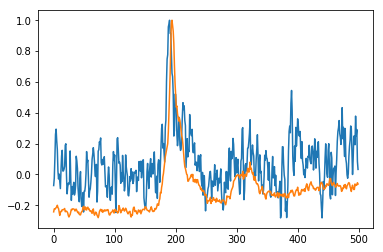

In [12]:
print("Total of "+str(num_classes)+" classes.")
print("Data mean-centered, normalized and hot-encoded.")
print("Total of "+str(len(X_train))+" training samples.")
plt.plot(X_test[0])
plt.plot(X_train[0])
plt.show()

In [13]:
model = Sequential()
activation = 'relu'
model.add(Convolution1D(2, 9, input_shape=(500,1), activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(2, 7, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(4, 7, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(4, 5, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Convolution1D(8, 3, activation=activation))
model.add(AveragePooling1D())
model.add(BatchNormalization())

model.add(Dropout(0.10))
model.add(Convolution1D(3, 1))
model.add(GlobalAveragePooling1D())

model.add(Activation('softmax', name='loss'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
print("CNN Model created.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 492, 2)            20        
_________________________________________________________________
average_pooling1d_1 (Average (None, 246, 2)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 246, 2)            8         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 240, 2)            30        
_________________________________________________________________
average_pooling1d_2 (Average (None, 120, 2)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 2)            8         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 114, 4)            60        
__________

In [14]:
epochs = 1000
batch_size = 512
seed = 7

In [16]:
np.random.seed(seed)

In [17]:
best_model_file = "highest_val_acc_weights_epoch{epoch:02d}-val_acc{val_acc:.3f}_cnn.h5"

In [18]:
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [25]:
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_test, y_test),
                 nb_epoch=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)
print("done")

Train on 134200 samples, validate on 474 samples
Epoch 1/1000
   512/134200 [..............................] - ETA: 46s - loss: 0.1186 - acc: 0.9590

134200/134200 [==============================] - 33s 246us/step - loss: 0.1212 - acc: 0.9559 - val_loss: 0.0643 - val_acc: 0.9810

Epoch 00001: val_acc did not improve from 0.98101
Epoch 2/1000
134200/134200 [==============================] - 31s 229us/step - loss: 0.1187 - acc: 0.9568 - val_loss: 0.1064 - val_acc: 0.9578

Epoch 00002: val_acc did not improve from 0.98101
Epoch 3/1000
134200/134200 [==============================] - 31s 232us/step - loss: 0.1199 - acc: 0.9558 - val_loss: 0.0615 - val_acc: 0.9789

Epoch 00003: val_acc did not improve from 0.98101
Epoch 4/1000
134200/134200 [==============================] - 39s 291us/step - loss: 0.1176 - acc: 0.9565 - val_loss: 0.0780 - val_acc: 0.9599

Epoch 00004: val_acc did not improve from 0.98101
Epoch 5/1000
134200/134200 [==============================] - 36s 267us/step - loss: 0.1162 - acc: 0.9572 - val_loss: 0.0628 - val_acc: 0.9789

Epoch 00005: val_acc did not improve from 0.98101
Epoch 6/1000
134200/134200 [===============

134200/134200 [==============================] - 29s 219us/step - loss: 0.1007 - acc: 0.9624 - val_loss: 0.0553 - val_acc: 0.9852

Epoch 00042: val_acc did not improve from 0.98734
Epoch 43/1000
134200/134200 [==============================] - 30s 225us/step - loss: 0.0998 - acc: 0.9629 - val_loss: 0.1055 - val_acc: 0.9684

Epoch 00043: val_acc did not improve from 0.98734
Epoch 44/1000
134200/134200 [==============================] - 28s 210us/step - loss: 0.0988 - acc: 0.9632 - val_loss: 0.0585 - val_acc: 0.9810

Epoch 00044: val_acc did not improve from 0.98734
Epoch 45/1000
134200/134200 [==============================] - 29s 213us/step - loss: 0.0983 - acc: 0.9635 - val_loss: 0.0673 - val_acc: 0.9810

Epoch 00045: val_acc did not improve from 0.98734
Epoch 46/1000
134200/134200 [==============================] - 33s 246us/step - loss: 0.0991 - acc: 0.9628 - val_loss: 0.0787 - val_acc: 0.9662

Epoch 00046: val_acc did not improve from 0.98734
Epoch 47/1000
134200/134200 [==========

134200/134200 [==============================] - 27s 200us/step - loss: 0.0928 - acc: 0.9661 - val_loss: 0.6661 - val_acc: 0.8354

Epoch 00084: val_acc did not improve from 0.98734
Epoch 85/1000
134200/134200 [==============================] - 27s 202us/step - loss: 0.0918 - acc: 0.9665 - val_loss: 0.4519 - val_acc: 0.8481

Epoch 00085: val_acc did not improve from 0.98734
Epoch 86/1000
134200/134200 [==============================] - 28s 211us/step - loss: 0.0927 - acc: 0.9668 - val_loss: 0.0718 - val_acc: 0.9810

Epoch 00086: val_acc did not improve from 0.98734
Epoch 87/1000
134200/134200 [==============================] - 27s 203us/step - loss: 0.0925 - acc: 0.9661 - val_loss: 0.0693 - val_acc: 0.9789

Epoch 00087: val_acc did not improve from 0.98734
Epoch 88/1000
134200/134200 [==============================] - 31s 228us/step - loss: 0.0914 - acc: 0.9664 - val_loss: 0.0466 - val_acc: 0.9852

Epoch 00088: val_acc did not improve from 0.98734
Epoch 89/1000
134200/134200 [==========

134200/134200 [==============================] - 28s 211us/step - loss: 0.0868 - acc: 0.9680 - val_loss: 0.0622 - val_acc: 0.9768

Epoch 00126: val_acc did not improve from 0.98734
Epoch 127/1000
134200/134200 [==============================] - 29s 216us/step - loss: 0.0886 - acc: 0.9677 - val_loss: 0.0671 - val_acc: 0.9810

Epoch 00127: val_acc did not improve from 0.98734
Epoch 128/1000
134200/134200 [==============================] - 29s 220us/step - loss: 0.0889 - acc: 0.9676 - val_loss: 0.1295 - val_acc: 0.9515

Epoch 00128: val_acc did not improve from 0.98734
Epoch 129/1000
134200/134200 [==============================] - 30s 227us/step - loss: 0.0882 - acc: 0.9677 - val_loss: 0.0468 - val_acc: 0.9810

Epoch 00129: val_acc did not improve from 0.98734
Epoch 130/1000
134200/134200 [==============================] - 28s 211us/step - loss: 0.0856 - acc: 0.9685 - val_loss: 0.0658 - val_acc: 0.9810

Epoch 00130: val_acc did not improve from 0.98734
Epoch 131/1000
134200/134200 [=====

134200/134200 [==============================] - 28s 209us/step - loss: 0.0859 - acc: 0.9685 - val_loss: 0.0653 - val_acc: 0.9831

Epoch 00168: val_acc did not improve from 0.98734
Epoch 169/1000
134200/134200 [==============================] - 28s 205us/step - loss: 0.0857 - acc: 0.9680 - val_loss: 0.0776 - val_acc: 0.9810

Epoch 00169: val_acc did not improve from 0.98734
Epoch 170/1000
134200/134200 [==============================] - 28s 206us/step - loss: 0.0848 - acc: 0.9686 - val_loss: 0.0740 - val_acc: 0.9662

Epoch 00170: val_acc did not improve from 0.98734
Epoch 171/1000
134200/134200 [==============================] - 27s 204us/step - loss: 0.0858 - acc: 0.9685 - val_loss: 0.0763 - val_acc: 0.9789

Epoch 00171: val_acc did not improve from 0.98734
Epoch 172/1000
134200/134200 [==============================] - 30s 225us/step - loss: 0.0852 - acc: 0.9683 - val_loss: 0.0728 - val_acc: 0.9768

Epoch 00172: val_acc did not improve from 0.98734
Epoch 173/1000
134200/134200 [=====

134200/134200 [==============================] - 30s 221us/step - loss: 0.0833 - acc: 0.9687 - val_loss: 0.0572 - val_acc: 0.9789

Epoch 00210: val_acc did not improve from 0.98734
Epoch 211/1000
134200/134200 [==============================] - 30s 225us/step - loss: 0.0821 - acc: 0.9697 - val_loss: 0.0640 - val_acc: 0.9768

Epoch 00211: val_acc did not improve from 0.98734
Epoch 212/1000
134200/134200 [==============================] - 31s 227us/step - loss: 0.0814 - acc: 0.9698 - val_loss: 0.1093 - val_acc: 0.9473

Epoch 00212: val_acc did not improve from 0.98734
Epoch 213/1000
134200/134200 [==============================] - 29s 216us/step - loss: 0.0829 - acc: 0.9698 - val_loss: 0.0653 - val_acc: 0.9810

Epoch 00213: val_acc did not improve from 0.98734
Epoch 214/1000
134200/134200 [==============================] - 28s 209us/step - loss: 0.0831 - acc: 0.9692 - val_loss: 0.0515 - val_acc: 0.9810

Epoch 00214: val_acc did not improve from 0.98734
Epoch 215/1000
134200/134200 [=====

134200/134200 [==============================] - 31s 233us/step - loss: 0.0831 - acc: 0.9696 - val_loss: 0.0717 - val_acc: 0.9768

Epoch 00252: val_acc did not improve from 0.98734
Epoch 253/1000
134200/134200 [==============================] - 29s 215us/step - loss: 0.0805 - acc: 0.9703 - val_loss: 0.0571 - val_acc: 0.9789

Epoch 00253: val_acc did not improve from 0.98734
Epoch 254/1000
134200/134200 [==============================] - 29s 213us/step - loss: 0.0813 - acc: 0.9703 - val_loss: 0.0649 - val_acc: 0.9789

Epoch 00254: val_acc did not improve from 0.98734
Epoch 255/1000
134200/134200 [==============================] - 28s 211us/step - loss: 0.0815 - acc: 0.9699 - val_loss: 0.0981 - val_acc: 0.9557

Epoch 00255: val_acc did not improve from 0.98734
Epoch 256/1000
134200/134200 [==============================] - 46s 342us/step - loss: 0.0817 - acc: 0.9696 - val_loss: 0.0556 - val_acc: 0.9789

Epoch 00256: val_acc did not improve from 0.98734
Epoch 257/1000
134200/134200 [=====

134200/134200 [==============================] - 32s 241us/step - loss: 0.0814 - acc: 0.9699 - val_loss: 0.0688 - val_acc: 0.9726

Epoch 00294: val_acc did not improve from 0.98734
Epoch 295/1000
134200/134200 [==============================] - 31s 232us/step - loss: 0.0805 - acc: 0.9702 - val_loss: 0.0557 - val_acc: 0.9852

Epoch 00295: val_acc did not improve from 0.98734
Epoch 296/1000
134200/134200 [==============================] - 33s 245us/step - loss: 0.0820 - acc: 0.9699 - val_loss: 0.0544 - val_acc: 0.9831

Epoch 00296: val_acc did not improve from 0.98734
Epoch 297/1000
134200/134200 [==============================] - 34s 253us/step - loss: 0.0814 - acc: 0.9698 - val_loss: 0.0596 - val_acc: 0.9831

Epoch 00297: val_acc did not improve from 0.98734
Epoch 298/1000
134200/134200 [==============================] - 31s 229us/step - loss: 0.0820 - acc: 0.9697 - val_loss: 0.0909 - val_acc: 0.9662

Epoch 00298: val_acc did not improve from 0.98734
Epoch 299/1000
134200/134200 [=====

134200/134200 [==============================] - 33s 244us/step - loss: 0.0817 - acc: 0.9699 - val_loss: 0.0581 - val_acc: 0.9810

Epoch 00336: val_acc did not improve from 0.98734
Epoch 337/1000
134200/134200 [==============================] - 33s 246us/step - loss: 0.0818 - acc: 0.9698 - val_loss: 0.0735 - val_acc: 0.9789

Epoch 00337: val_acc did not improve from 0.98734
Epoch 338/1000
134200/134200 [==============================] - 33s 245us/step - loss: 0.0802 - acc: 0.9703 - val_loss: 0.0574 - val_acc: 0.9768

Epoch 00338: val_acc did not improve from 0.98734
Epoch 339/1000
134200/134200 [==============================] - 33s 243us/step - loss: 0.0804 - acc: 0.9703 - val_loss: 0.1058 - val_acc: 0.9599

Epoch 00339: val_acc did not improve from 0.98734
Epoch 340/1000
134200/134200 [==============================] - 33s 246us/step - loss: 0.0806 - acc: 0.9705 - val_loss: 0.0617 - val_acc: 0.9810

Epoch 00340: val_acc did not improve from 0.98734
Epoch 341/1000
134200/134200 [=====

Epoch 378/1000
134200/134200 [==============================] - 41s 305us/step - loss: 0.0811 - acc: 0.9700 - val_loss: 0.0602 - val_acc: 0.9789

Epoch 00378: val_acc did not improve from 0.98734
Epoch 379/1000
134200/134200 [==============================] - 35s 260us/step - loss: 0.0802 - acc: 0.9705 - val_loss: 0.1065 - val_acc: 0.9536

Epoch 00379: val_acc did not improve from 0.98734
Epoch 380/1000
134200/134200 [==============================] - 39s 290us/step - loss: 0.0810 - acc: 0.9707 - val_loss: 0.0663 - val_acc: 0.9747

Epoch 00380: val_acc did not improve from 0.98734
Epoch 381/1000
134200/134200 [==============================] - 33s 242us/step - loss: 0.0822 - acc: 0.9697 - val_loss: 0.0676 - val_acc: 0.9789

Epoch 00381: val_acc did not improve from 0.98734
Epoch 382/1000
134200/134200 [==============================] - 41s 306us/step - loss: 0.0803 - acc: 0.9702 - val_loss: 0.0562 - val_acc: 0.9768

Epoch 00382: val_acc did not improve from 0.98734
Epoch 383/1000
13420

134200/134200 [==============================] - 60s 446us/step - loss: 0.0807 - acc: 0.9700 - val_loss: 0.0555 - val_acc: 0.9810

Epoch 00420: val_acc did not improve from 0.98734
Epoch 421/1000
134200/134200 [==============================] - 61s 451us/step - loss: 0.0819 - acc: 0.9694 - val_loss: 0.0644 - val_acc: 0.9810

Epoch 00421: val_acc did not improve from 0.98734
Epoch 422/1000
134200/134200 [==============================] - 62s 461us/step - loss: 0.0798 - acc: 0.9704 - val_loss: 0.0590 - val_acc: 0.9789

Epoch 00422: val_acc did not improve from 0.98734
Epoch 423/1000
134200/134200 [==============================] - 63s 467us/step - loss: 0.0812 - acc: 0.9697 - val_loss: 0.0622 - val_acc: 0.9810

Epoch 00423: val_acc did not improve from 0.98734
Epoch 424/1000
134200/134200 [==============================] - 66s 489us/step - loss: 0.0804 - acc: 0.9695 - val_loss: 0.0740 - val_acc: 0.9789

Epoch 00424: val_acc did not improve from 0.98734
Epoch 425/1000
134200/134200 [=====

134200/134200 [==============================] - 37s 272us/step - loss: 0.0797 - acc: 0.9709 - val_loss: 0.0691 - val_acc: 0.9768

Epoch 00462: val_acc did not improve from 0.98734
Epoch 463/1000
134200/134200 [==============================] - 37s 273us/step - loss: 0.0799 - acc: 0.9701 - val_loss: 0.1078 - val_acc: 0.9641

Epoch 00463: val_acc did not improve from 0.98734
Epoch 464/1000
134200/134200 [==============================] - 37s 274us/step - loss: 0.0803 - acc: 0.9704 - val_loss: 0.0676 - val_acc: 0.9789

Epoch 00464: val_acc did not improve from 0.98734
Epoch 465/1000
134200/134200 [==============================] - 37s 273us/step - loss: 0.0807 - acc: 0.9703 - val_loss: 0.0712 - val_acc: 0.9768

Epoch 00465: val_acc did not improve from 0.98734
Epoch 466/1000
134200/134200 [==============================] - 37s 278us/step - loss: 0.0805 - acc: 0.9703 - val_loss: 0.1558 - val_acc: 0.9367

Epoch 00466: val_acc did not improve from 0.98734
Epoch 467/1000
134200/134200 [=====

134200/134200 [==============================] - 37s 274us/step - loss: 0.0799 - acc: 0.9705 - val_loss: 0.0615 - val_acc: 0.9789

Epoch 00504: val_acc did not improve from 0.98734
Epoch 505/1000
134200/134200 [==============================] - 37s 276us/step - loss: 0.0793 - acc: 0.9707 - val_loss: 0.0768 - val_acc: 0.9726

Epoch 00505: val_acc did not improve from 0.98734
Epoch 506/1000
134200/134200 [==============================] - 37s 273us/step - loss: 0.0799 - acc: 0.9706 - val_loss: 0.0653 - val_acc: 0.9789

Epoch 00506: val_acc did not improve from 0.98734
Epoch 507/1000
134200/134200 [==============================] - 40s 301us/step - loss: 0.0796 - acc: 0.9704 - val_loss: 0.0659 - val_acc: 0.9789

Epoch 00507: val_acc did not improve from 0.98734
Epoch 508/1000
134200/134200 [==============================] - 37s 273us/step - loss: 0.0803 - acc: 0.9703 - val_loss: 0.0720 - val_acc: 0.9789

Epoch 00508: val_acc did not improve from 0.98734
Epoch 509/1000
134200/134200 [=====

134200/134200 [==============================] - 36s 268us/step - loss: 0.0799 - acc: 0.9697 - val_loss: 0.0719 - val_acc: 0.9810

Epoch 00546: val_acc did not improve from 0.98734
Epoch 547/1000
134200/134200 [==============================] - 36s 269us/step - loss: 0.0791 - acc: 0.9709 - val_loss: 0.0821 - val_acc: 0.9789

Epoch 00547: val_acc did not improve from 0.98734
Epoch 548/1000
134200/134200 [==============================] - 37s 272us/step - loss: 0.0806 - acc: 0.9699 - val_loss: 0.0775 - val_acc: 0.9726

Epoch 00548: val_acc did not improve from 0.98734
Epoch 549/1000
134200/134200 [==============================] - 38s 285us/step - loss: 0.0797 - acc: 0.9700 - val_loss: 0.0730 - val_acc: 0.9789

Epoch 00549: val_acc did not improve from 0.98734
Epoch 550/1000
134200/134200 [==============================] - 46s 343us/step - loss: 0.0800 - acc: 0.9702 - val_loss: 0.0764 - val_acc: 0.9789

Epoch 00550: val_acc did not improve from 0.98734
Epoch 551/1000
134200/134200 [=====

134200/134200 [==============================] - 36s 267us/step - loss: 0.0780 - acc: 0.9711 - val_loss: 0.0845 - val_acc: 0.9747

Epoch 00588: val_acc did not improve from 0.98734
Epoch 589/1000
134200/134200 [==============================] - 36s 271us/step - loss: 0.0798 - acc: 0.9707 - val_loss: 0.0724 - val_acc: 0.9789

Epoch 00589: val_acc did not improve from 0.98734
Epoch 590/1000
134200/134200 [==============================] - 36s 270us/step - loss: 0.0782 - acc: 0.9713 - val_loss: 0.1467 - val_acc: 0.9430

Epoch 00590: val_acc did not improve from 0.98734
Epoch 591/1000
134200/134200 [==============================] - 37s 275us/step - loss: 0.0784 - acc: 0.9711 - val_loss: 0.0691 - val_acc: 0.9747

Epoch 00591: val_acc did not improve from 0.98734
Epoch 592/1000
134200/134200 [==============================] - 43s 321us/step - loss: 0.0797 - acc: 0.9708 - val_loss: 0.1270 - val_acc: 0.9536

Epoch 00592: val_acc did not improve from 0.98734
Epoch 593/1000
134200/134200 [=====

134200/134200 [==============================] - 35s 264us/step - loss: 0.0791 - acc: 0.9705 - val_loss: 0.0745 - val_acc: 0.9747

Epoch 00630: val_acc did not improve from 0.98734
Epoch 631/1000
134200/134200 [==============================] - 35s 264us/step - loss: 0.0794 - acc: 0.9708 - val_loss: 0.0585 - val_acc: 0.9810

Epoch 00631: val_acc did not improve from 0.98734
Epoch 632/1000
134200/134200 [==============================] - 35s 264us/step - loss: 0.0783 - acc: 0.9710 - val_loss: 0.0608 - val_acc: 0.9810

Epoch 00632: val_acc did not improve from 0.98734
Epoch 633/1000
134200/134200 [==============================] - 36s 267us/step - loss: 0.0788 - acc: 0.9710 - val_loss: 0.0625 - val_acc: 0.9789

Epoch 00633: val_acc did not improve from 0.98734
Epoch 634/1000
134200/134200 [==============================] - 37s 274us/step - loss: 0.0785 - acc: 0.9710 - val_loss: 0.0642 - val_acc: 0.9768

Epoch 00634: val_acc did not improve from 0.98734
Epoch 635/1000
134200/134200 [=====

134200/134200 [==============================] - 39s 291us/step - loss: 0.0788 - acc: 0.9709 - val_loss: 0.0652 - val_acc: 0.9747

Epoch 00672: val_acc did not improve from 0.98734
Epoch 673/1000
134200/134200 [==============================] - 38s 280us/step - loss: 0.0771 - acc: 0.9715 - val_loss: 0.0602 - val_acc: 0.9810

Epoch 00673: val_acc did not improve from 0.98734
Epoch 674/1000
134200/134200 [==============================] - 43s 319us/step - loss: 0.0764 - acc: 0.9718 - val_loss: 0.0576 - val_acc: 0.9789

Epoch 00674: val_acc did not improve from 0.98734
Epoch 675/1000
134200/134200 [==============================] - 50s 376us/step - loss: 0.0768 - acc: 0.9720 - val_loss: 0.1078 - val_acc: 0.9641

Epoch 00675: val_acc did not improve from 0.98734
Epoch 676/1000
134200/134200 [==============================] - 6669s 50ms/step - loss: 0.0772 - acc: 0.9714 - val_loss: 0.0656 - val_acc: 0.9705

Epoch 00676: val_acc did not improve from 0.98734
Epoch 677/1000
134200/134200 [====

134200/134200 [==============================] - 28s 211us/step - loss: 0.0780 - acc: 0.9715 - val_loss: 0.0507 - val_acc: 0.9789

Epoch 00714: val_acc did not improve from 0.98734
Epoch 715/1000
134200/134200 [==============================] - 30s 225us/step - loss: 0.0765 - acc: 0.9718 - val_loss: 0.0571 - val_acc: 0.9768

Epoch 00715: val_acc did not improve from 0.98734
Epoch 716/1000
134200/134200 [==============================] - 30s 222us/step - loss: 0.0758 - acc: 0.9722 - val_loss: 0.0538 - val_acc: 0.9810

Epoch 00716: val_acc did not improve from 0.98734
Epoch 717/1000
134200/134200 [==============================] - 29s 213us/step - loss: 0.0767 - acc: 0.9716 - val_loss: 0.0554 - val_acc: 0.9747

Epoch 00717: val_acc did not improve from 0.98734
Epoch 718/1000
134200/134200 [==============================] - 30s 221us/step - loss: 0.0772 - acc: 0.9720 - val_loss: 0.0823 - val_acc: 0.9641

Epoch 00718: val_acc did not improve from 0.98734
Epoch 719/1000
134200/134200 [=====

134200/134200 [==============================] - 29s 215us/step - loss: 0.0763 - acc: 0.9721 - val_loss: 0.0617 - val_acc: 0.9789

Epoch 00756: val_acc did not improve from 0.98734
Epoch 757/1000
134200/134200 [==============================] - 32s 235us/step - loss: 0.0765 - acc: 0.9720 - val_loss: 0.0798 - val_acc: 0.9662

Epoch 00757: val_acc did not improve from 0.98734
Epoch 758/1000
134200/134200 [==============================] - 33s 248us/step - loss: 0.0760 - acc: 0.9722 - val_loss: 0.0498 - val_acc: 0.9810

Epoch 00758: val_acc did not improve from 0.98734
Epoch 759/1000
134200/134200 [==============================] - 28s 212us/step - loss: 0.0751 - acc: 0.9724 - val_loss: 0.0699 - val_acc: 0.9726

Epoch 00759: val_acc did not improve from 0.98734
Epoch 760/1000
134200/134200 [==============================] - 28s 207us/step - loss: 0.0762 - acc: 0.9726 - val_loss: 0.0596 - val_acc: 0.9768

Epoch 00760: val_acc did not improve from 0.98734
Epoch 761/1000
134200/134200 [=====

134200/134200 [==============================] - 28s 208us/step - loss: 0.0759 - acc: 0.9722 - val_loss: 0.0622 - val_acc: 0.9768

Epoch 00798: val_acc did not improve from 0.98734
Epoch 799/1000
134200/134200 [==============================] - 28s 208us/step - loss: 0.0741 - acc: 0.9727 - val_loss: 0.0554 - val_acc: 0.9810

Epoch 00799: val_acc did not improve from 0.98734
Epoch 800/1000
134200/134200 [==============================] - 29s 217us/step - loss: 0.0752 - acc: 0.9719 - val_loss: 0.0520 - val_acc: 0.9768

Epoch 00800: val_acc did not improve from 0.98734
Epoch 801/1000
134200/134200 [==============================] - 29s 215us/step - loss: 0.0757 - acc: 0.9720 - val_loss: 0.0575 - val_acc: 0.9789

Epoch 00801: val_acc did not improve from 0.98734
Epoch 802/1000
134200/134200 [==============================] - 34s 252us/step - loss: 0.0756 - acc: 0.9723 - val_loss: 0.0516 - val_acc: 0.9789

Epoch 00802: val_acc did not improve from 0.98734
Epoch 803/1000
134200/134200 [=====

134200/134200 [==============================] - 28s 210us/step - loss: 0.0760 - acc: 0.9720 - val_loss: 0.0680 - val_acc: 0.9726

Epoch 00840: val_acc did not improve from 0.98734
Epoch 841/1000
134200/134200 [==============================] - 28s 209us/step - loss: 0.0741 - acc: 0.9729 - val_loss: 0.0656 - val_acc: 0.9768

Epoch 00841: val_acc did not improve from 0.98734
Epoch 842/1000
134200/134200 [==============================] - 28s 212us/step - loss: 0.0745 - acc: 0.9727 - val_loss: 0.0711 - val_acc: 0.9831

Epoch 00842: val_acc did not improve from 0.98734
Epoch 843/1000
134200/134200 [==============================] - 28s 208us/step - loss: 0.0751 - acc: 0.9726 - val_loss: 0.0797 - val_acc: 0.9726

Epoch 00843: val_acc did not improve from 0.98734
Epoch 844/1000
134200/134200 [==============================] - 27s 205us/step - loss: 0.0754 - acc: 0.9722 - val_loss: 0.0864 - val_acc: 0.9705

Epoch 00844: val_acc did not improve from 0.98734
Epoch 845/1000
134200/134200 [=====

134200/134200 [==============================] - 29s 218us/step - loss: 0.0755 - acc: 0.9721 - val_loss: 0.0522 - val_acc: 0.9831

Epoch 00882: val_acc did not improve from 0.98734
Epoch 883/1000
134200/134200 [==============================] - 28s 211us/step - loss: 0.0752 - acc: 0.9719 - val_loss: 0.0595 - val_acc: 0.9789

Epoch 00883: val_acc did not improve from 0.98734
Epoch 884/1000
134200/134200 [==============================] - 28s 207us/step - loss: 0.0746 - acc: 0.9724 - val_loss: 0.0551 - val_acc: 0.9810

Epoch 00884: val_acc did not improve from 0.98734
Epoch 885/1000
134200/134200 [==============================] - 28s 207us/step - loss: 0.0754 - acc: 0.9720 - val_loss: 0.0628 - val_acc: 0.9768

Epoch 00885: val_acc did not improve from 0.98734
Epoch 886/1000
134200/134200 [==============================] - 29s 213us/step - loss: 0.0753 - acc: 0.9722 - val_loss: 0.0510 - val_acc: 0.9768

Epoch 00886: val_acc did not improve from 0.98734
Epoch 887/1000
134200/134200 [=====

134200/134200 [==============================] - 29s 216us/step - loss: 0.0757 - acc: 0.9721 - val_loss: 0.0593 - val_acc: 0.9768

Epoch 00924: val_acc did not improve from 0.98734
Epoch 925/1000
134200/134200 [==============================] - 30s 222us/step - loss: 0.0742 - acc: 0.9729 - val_loss: 0.0556 - val_acc: 0.9789

Epoch 00925: val_acc did not improve from 0.98734
Epoch 926/1000
134200/134200 [==============================] - 49s 367us/step - loss: 0.0744 - acc: 0.9723 - val_loss: 0.0505 - val_acc: 0.9768

Epoch 00926: val_acc did not improve from 0.98734
Epoch 927/1000
134200/134200 [==============================] - 35s 258us/step - loss: 0.0738 - acc: 0.9727 - val_loss: 0.0681 - val_acc: 0.9705

Epoch 00927: val_acc did not improve from 0.98734
Epoch 928/1000
134200/134200 [==============================] - 31s 233us/step - loss: 0.0763 - acc: 0.9723 - val_loss: 0.0675 - val_acc: 0.9789

Epoch 00928: val_acc did not improve from 0.98734
Epoch 929/1000
134200/134200 [=====

134200/134200 [==============================] - 29s 214us/step - loss: 0.0752 - acc: 0.9725 - val_loss: 0.0724 - val_acc: 0.9726

Epoch 00966: val_acc did not improve from 0.98734
Epoch 967/1000
134200/134200 [==============================] - 29s 216us/step - loss: 0.0752 - acc: 0.9725 - val_loss: 0.0604 - val_acc: 0.9810

Epoch 00967: val_acc did not improve from 0.98734
Epoch 968/1000
134200/134200 [==============================] - 29s 215us/step - loss: 0.0744 - acc: 0.9725 - val_loss: 0.0582 - val_acc: 0.9768

Epoch 00968: val_acc did not improve from 0.98734
Epoch 969/1000
134200/134200 [==============================] - 31s 231us/step - loss: 0.0757 - acc: 0.9724 - val_loss: 0.0940 - val_acc: 0.9599

Epoch 00969: val_acc did not improve from 0.98734
Epoch 970/1000
134200/134200 [==============================] - 29s 218us/step - loss: 0.0766 - acc: 0.9722 - val_loss: 0.0671 - val_acc: 0.9810

Epoch 00970: val_acc did not improve from 0.98734
Epoch 971/1000
134200/134200 [=====

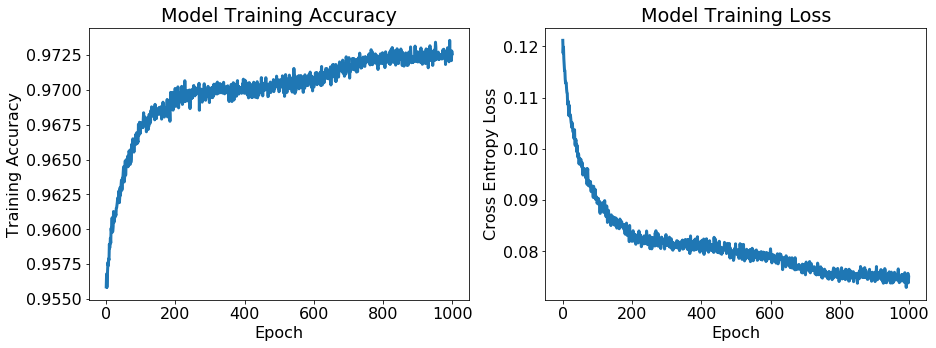

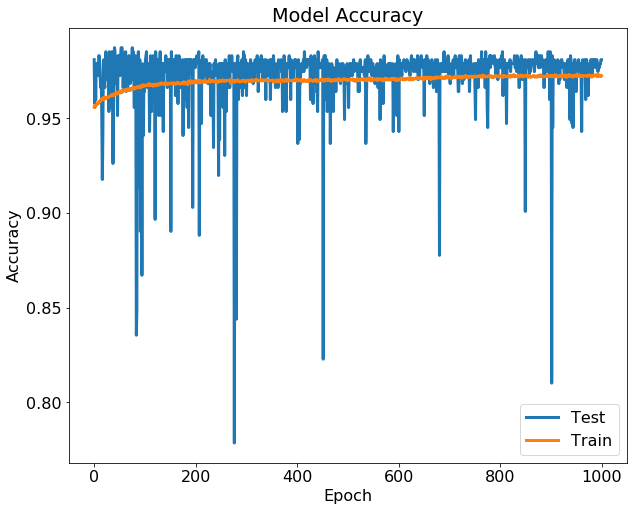

In [36]:
plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

plt.subplot(1, 2, 1)
plt.plot(hist.history['acc'], linewidth = 3)
plt.title('Model Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], linewidth = 3)
plt.title('Model Training Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.savefig('Untitled Folder')
plt.show()

plt.figure(figsize=(10, 8))

plt.plot(hist.history['val_acc'], linewidth = 3)
plt.plot(hist.history['acc'], linewidth = 3)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='lower right')
plt.savefig('Untitled Folder')

plt.show()

In [37]:
y_test_pred, y_test_labels=[], []

In [38]:
for i in range(0, len(X_test)):
    y_test_pred.append(np.argmax(model.predict(X_test[i:i+1])))
    y_test_labels.append(np.argmax(y_test[i]))

In [39]:
print("Confusion Matrix of Test Set")
conf_matrix = pd.DataFrame(confusion_matrix(y_pred=y_test_pred, y_true=y_test_labels))
conf_matrix.columns = ["Mn2+", "Mn3+", "Mn4+" ]
conf_matrix = pd.DataFrame.transpose(conf_matrix)
conf_matrix.columns = ["Mn2+", "Mn3+", "Mn4+" ]
conf_matrix = pd.DataFrame.transpose(conf_matrix)
print(conf_matrix)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Confusion Matrix of Test Set
      Mn2+  Mn3+  Mn4+
Mn2+   157     0     0
Mn3+     2   136     3
Mn4+     0     4   172
Accuracy: 98.10%
